<a href="https://colab.research.google.com/github/kuzovkov/neural-university/blob/main/%D0%94%D0%97_Ultra_Pro_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [1]:
# Ваше решение

import gdown

# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)

# Разархивация датасета в директорию 'content/cars'
!unzip -qo "middle_fmr.zip" -d /content/cars

import os
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/cars/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

from PIL import Image                     # Отрисовка изображений
import random                             # Генерация случайных чисел
import matplotlib.pyplot as plt           # Отрисовка графиков

%matplotlib inline


Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


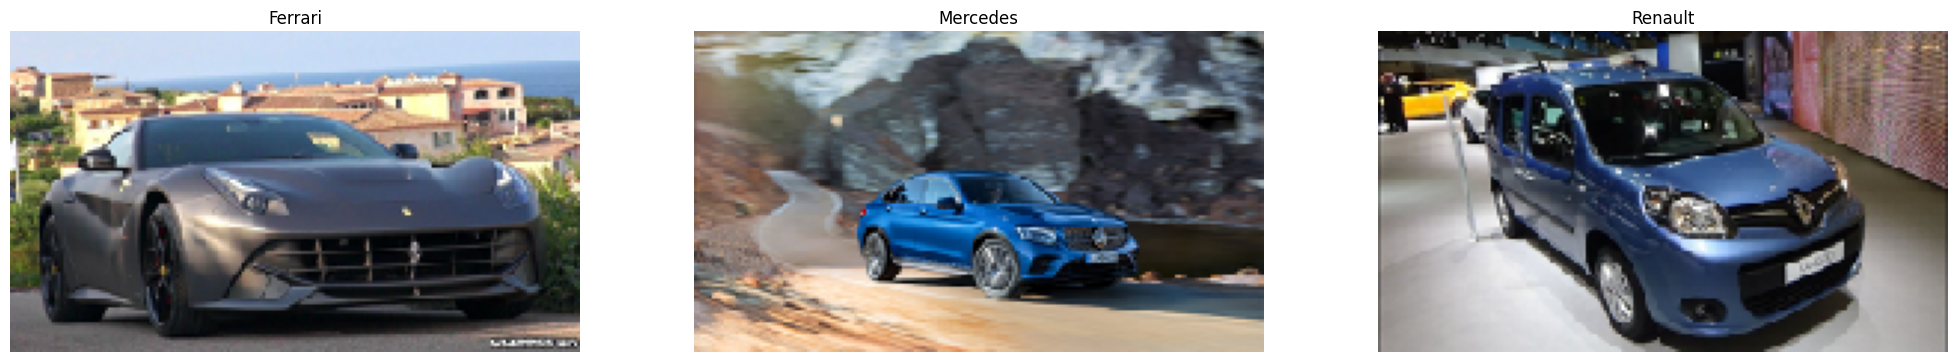

In [3]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):
    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'
    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))
    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [4]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} машин')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print('Общий размер базы для обучения:', len(data_labels))

Размер класса Ferrari составляет 1088 машин
Размер класса Mercedes составляет 1161 машин
Размер класса Renault составляет 1178 машин
Общий размер базы для обучения: 3427


In [ ]:
# Задание единых размеров изображений

IMG_WIDTH = 128                           # Ширина изображения
IMG_HEIGHT = 64                           # Высота изображения

import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

# Нормированние массива изображений
x_data = x_data / 255.

В массив собрано 3427 фотографий следующей формы: (64, 128, 3)
Общий массив данных изображений следующей формы: (3427, 64, 128, 3)
Общий массив меток классов следующей формы: (3427,)


In [ ]:
# Подключение нужных слоев из модуля tensorflow.keras.layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))  # (64,128,256) --> (64,128,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (64,128,256) --> (21,42,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(Dropout(0.2, name='Third_D'))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (21,42,256) --> (7,14,256)
model.add(Dropout(0.2, name='Fourth_D'))  # (7,14,256) --> (7,14,256) нет изменений

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)
model.add(Dropout(0.2, name='Sixth_D'))  # (2,4,1024) --> (2,4,1024) нет изменений

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (2,4,1024) --> (2*4*1024) --> (8192)
model.add(Dense(2048, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(4096, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ First_C (Conv2D)                     │ (None, 64, 128, 256)        │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ First_B (BatchNormalization)         │ (None, 64, 128, 256)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_C (Conv2D)                    │ (None, 64, 128, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_M (MaxPooling2D)              │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_C (Conv2D)                     │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_B (BatchNormalization)         │ (None, 21, 42, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_D (Dropout)                    │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_C (Conv2D)                    │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_M (MaxPooling2D)              │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_D (Dropout)                   │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_D (Conv2D)                     │ (None, 7, 14, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_B (BatchNormalization)         │ (None, 7, 14, 512)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_C (Conv2D)                     │ (None, 7, 14, 1024)         │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_M (MaxPooling2D)               │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_D (Dropout)                    │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_1 (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_2 (Dense)                      │ (None, 2048)                │      16,779,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_3 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_4 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,865,539 (125.37 MB)

 Trainable params: 32,863,491 (125.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

history = model.fit(x_data,  # ----------------- x_train, примеры набора данных
                           y_data,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           shuffle=True,  # ----------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=25,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=35,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 353ms/step - accuracy: 0.5704 - loss: 1.2307 - val_accuracy: 0.0000e+00 - val_loss: 2.2412
Epoch 2/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - accuracy: 0.6651 - loss: 0.8095 - val_accuracy: 0.0000e+00 - val_loss: 2.9539
Epoch 3/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.7080 - loss: 0.7146 - val_accuracy: 0.0000e+00 - val_loss: 2.8551
Epoch 4/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.7126 - loss: 0.6980 - val_accuracy: 0.0000e+00 - val_loss: 3.5022
Epoch 5/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.7399 - loss: 0.6012 - val_accuracy: 0.0015 - val_loss: 2.5769
Epoch 6/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.7612 - loss: 0.5988 - val_accuracy: 0.0510 - val_loss: 2.5058
Epoch 7/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - accuracy: 0.8006 - loss: 0.5096 - val_accuracy: 0.1414 - val_loss: 2.3658
Epoch 8/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 

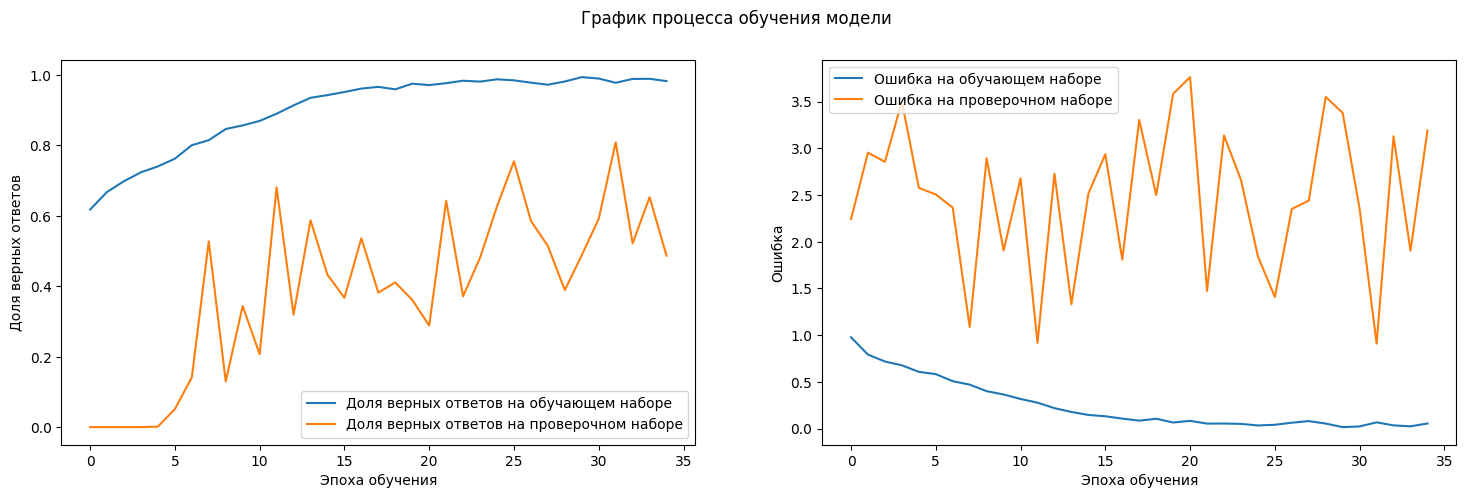

In [ ]:
# Вывод оценки ее работы на проверочных выборках
# Вывод графиков точности и ошибки
figsize=(18, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
           label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
           label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
           label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
           label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()


In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 60                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [ ]:
# Генераторы изображений
# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ First_C (Conv2D)                     │ (None, 64, 128, 256)        │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ First_B (BatchNormalization)         │ (None, 64, 128, 256)        │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_C (Conv2D)                    │ (None, 64, 128, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Second_M (MaxPooling2D)              │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_C (Conv2D)                     │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_B (BatchNormalization)         │ (None, 21, 42, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Third_D (Dropout)                    │ (None, 21, 42, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_C (Conv2D)                    │ (None, 21, 42, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_M (MaxPooling2D)              │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fourth_D (Dropout)                   │ (None, 7, 14, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_D (Conv2D)                     │ (None, 7, 14, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Fifth_B (BatchNormalization)         │ (None, 7, 14, 512)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_C (Conv2D)                     │ (None, 7, 14, 1024)         │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_M (MaxPooling2D)               │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sixth_D (Dropout)                    │ (None, 2, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_1 (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_2 (Dense)                      │ (None, 2048)                │      16,779,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_3 (Dense)                      │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Class_4 (Dense)                      │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,865,539 (125.37 MB)

 Trainable params: 32,863,491 (125.36 MB)

 Non-trainable params: 2,048 (8.00 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 66s 426ms/step - accuracy: 0.6890 - loss: 0.9189 - val_accuracy: 0.6029 - val_loss: 0.8993
Epoch 2/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 191ms/step - accuracy: 0.7384 - loss: 0.5958 - val_accuracy: 0.6856 - val_loss: 0.7267
Epoch 3/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.7748 - loss: 0.5518 - val_accuracy: 0.6775 - val_loss: 0.6969
Epoch 4/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.7793 - loss: 0.5286 - val_accuracy: 0.7277 - val_loss: 0.7263
Epoch 5/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - accuracy: 0.7944 - loss: 0.4846 - val_accuracy: 0.5835 - val_loss: 0.9577
Epoch 6/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.8263 - loss: 0.4622 - val_accuracy: 0.7326 - val_loss: 0.6044
Epoch 7/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.8218 - loss: 0.4390 - val_accuracy: 0.7520 - val_loss: 0.6860
Epoch 8/60
103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8320 - loss: 0

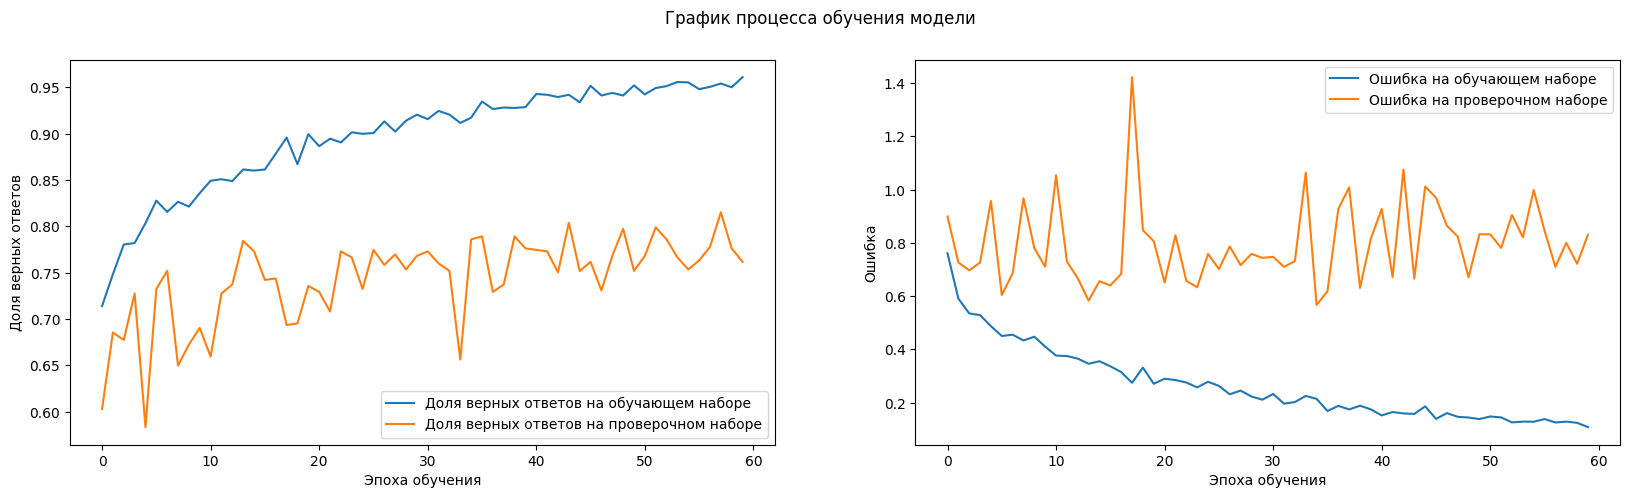

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step


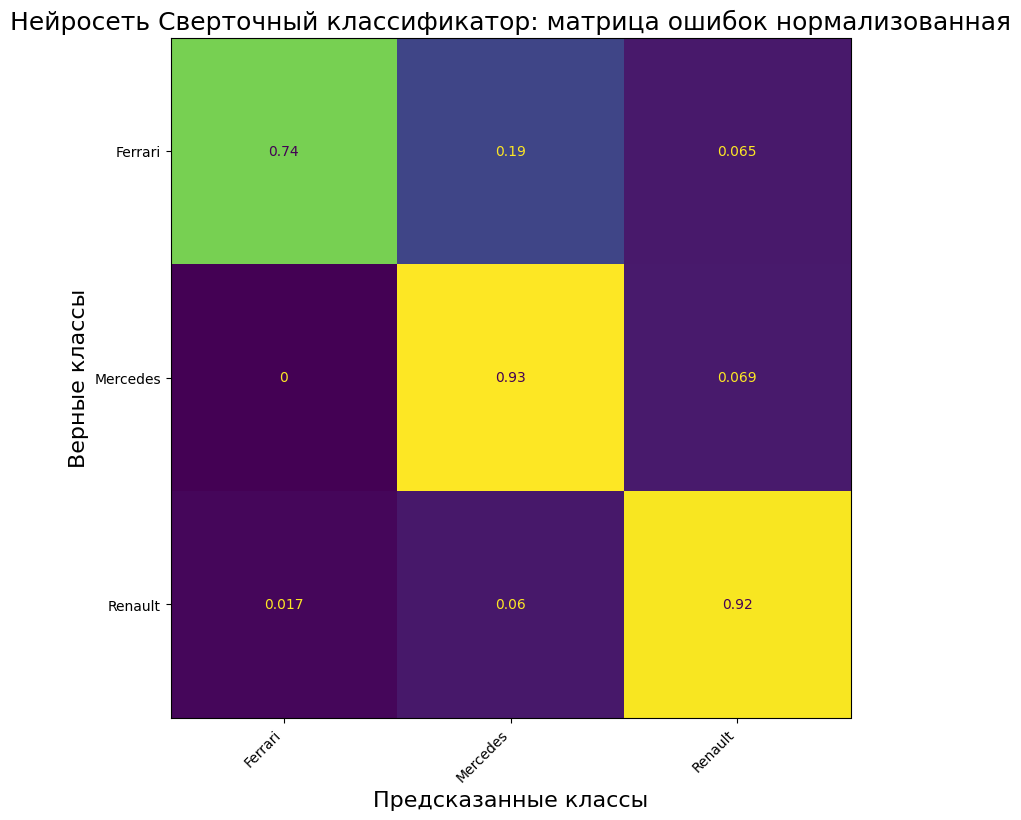

----------------------------------------------------------------------------------------------------
Нейросеть: Сверточный классификатор
Класс: Ferrari               74% сеть отнесла к классу Ferrari              - ВЕРНО :-)
Класс: Mercedes              93% сеть отнесла к классу Mercedes             - ВЕРНО :-)
Класс: Renault               92% сеть отнесла к классу Renault              - ВЕРНО :-)

Средняя точность распознавания:  87%


In [ ]:
# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

In [6]:
# использование готовой архитектуры
# Задание гиперпараметров
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 224                   # Ширина изображения для нейросети
IMG_HEIGHT          = 224                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 15                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

In [7]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

try:
  os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
except:
  pass

train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса

    try:
      os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    except:
      pass

    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


In [9]:
# Генераторы изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    #  rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                  #  rescale=1. / 255.
                )

In [10]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        # batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1],
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout

# Задаем параметры входящей картинки
img_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
img_size  = (IMG_HEIGHT, IMG_WIDTH)
my_random = None
# Задаем имя модели
model_name = 'EfficientNetB0'
# Генерируем экземпляр модели EfficientNetB0
base_model = EfficientNetB0(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
# Создаем выходной слой
x = base_model.output
x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate = .45, seed = my_random)(x)
#Создаем выходной полносвязный слой и присоединяем его к предыдущим слоям (количество нейронов совпадает с количеством классов
output = Dense(CLASS_COUNT, activation = 'softmax')(x)
# Собираем модель вместе
model = Model(inputs = base_model.input, outputs = output)
model.compile(optimizer=Adamax(.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Вывод сводки
#model.summary()

In [15]:
# Обучение модели с заданными параметрами
patience      = 1 # количество эпох, в течение которых необходимо отрегулировать lr, если отслеживаемое значение не улучшится
stop_patience = 6 # количество эпох ожидания перед остановкой обучения, если отслеживаемое значение не улучшится
threshold     = .9
factor        = .5
dwell         = True # если True и отслеживаемая метрика не улучшаются по сравнению с текущей эпохой, возвращают веса модели к весам предыдущей эпохи.
freeze        = False #
ask_epoch     = 10 # количество эпох, которые нужно выполнить, прежде чем спросить, хотите ли вы остановить обучение
batch_size = 20
# Размер пачки для валидации
test_batch_size = 50


history = model.fit (x = train_generator,  epochs = EPOCHS, validation_data = validation_generator, validation_steps = None,  shuffle = False,  initial_epoch = 0, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 172s 924ms/step - accuracy: 0.4944 - loss: 17.5713 - val_accuracy: 0.4036 - val_loss: 9.0595
Epoch 2/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 43s 419ms/step - accuracy: 0.3807 - loss: 6.6251 - val_accuracy: 0.4068 - val_loss: 6.3833
Epoch 3/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 427ms/step - accuracy: 0.3627 - loss: 5.9081 - val_accuracy: 0.3744 - val_loss: 5.5580
Epoch 4/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 43s 418ms/step - accuracy: 0.3343 - loss: 5.2622 - val_accuracy: 0.3598 - val_loss: 4.8470
Epoch 5/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 44s 423ms/step - accuracy: 0.3426 - loss: 4.6655 - val_accuracy: 0.3517 - val_loss: 4.2593
Epoch 6/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 448ms/step - accuracy: 0.3330 - loss: 4.1126 - val_accuracy: 0.3566 - val_loss: 3.7363
Epoch 7/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 43s 417ms/step - accuracy: 0.3433 - loss: 3.6142 - val_accuracy: 0.3679 - val_loss: 3.2914
Epoch 8/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.3536 - loss:

NameError: name 'figsize' is not defined

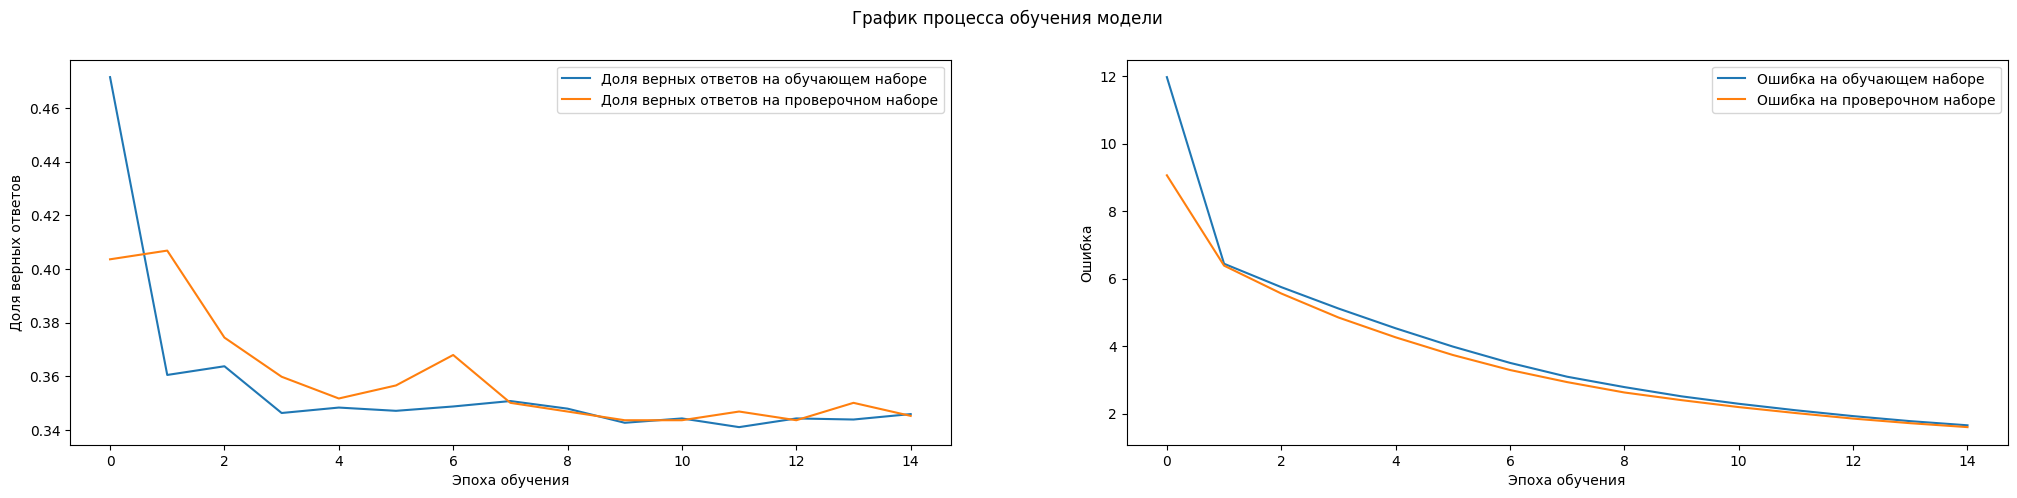

In [16]:
# Вывод графиков точности и ошибки
figsize = (25,5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
            label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
            label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()

In [18]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=55aef6becb03b1e17d4e993faeab93c9868fca443f77dfb35c8b9f0dbc830281
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import seaborn as sns
import logging
# В utils мы реализуем дополнительные функции для визуализации процессора обучения
import utils
# Настраиваем логирование
logging.getLogger("tensorflow").setLevel(logging.ERROR)
# Настраиваем стиль графиков
sns.set_style('darkgrid')
# Проверяем подходит ли наша GPU для tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)


Physical devices cannot be modified after being initialized


In [20]:
# Рисует график обучения
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range (start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss  = np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest  = vloss[index_loss]
    index_acc   = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'Лучшая эпоха= '+ str(index_loss + 1 + start_epoch)
    vc_label = 'Лучшая эпоха= '+ str(index_acc  + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols = 2, figsize = (20,8))
    axes[0].plot (Epochs,tloss, 'r', label = 'Потери при обучении')
    axes[0].plot (Epochs,vloss,'g',label='Потери при валидации' )
    axes[0].scatter (index_loss + 1 + start_epoch,val_lowest, s = 150, c = 'blue', label = sc_label)
    axes[0].set_title('Потери при валидации и обучении')
    axes[0].set_xlabel('Эпохи')
    axes[0].set_ylabel('Потери')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r', label = 'Точность при обучении')
    axes[1].plot (Epochs,vacc,'g', label = 'Точность при валидации')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s = 150, c = 'blue', label = vc_label)
    axes[1].set_title  ('Точность при валидации и обучении')
    axes[1].set_xlabel ('Эпохи')
    axes[1].set_ylabel ('Точность')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
# Создаем data_frame, в котором название папки является меткой класса изображений (коты и собаки в нашем случае)
# Каждому элементу data_frame будет присвоена метка (DX) и название файла (image)
# Функция возвращает объект frame
def load_data_frame(sdir):
    classlist = os.listdir(sdir)
    filepaths = []
    labels = []
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append( fpath.replace('\\', '/') )
            labels.append(klass)

    Fseries=pd.Series( filepaths, name = 'image' )
    Lseries=pd.Series(labels, name = 'dx')
    return pd.concat([Fseries, Lseries], axis=1)



In [31]:
# Размер картинки для подачи в модели
height   = 224
width    = 224
channels = 3

# Размер пачки для обучения
batch_size = 20
# Размер пачки для валидации
test_batch_size = 50

# Инициализаци рандом: None - всегда рандом, Число - повторяемый рандом
my_random = None

# Загружаем сгенерированные картинки (картинка должны лежать по папкам с названием их DX)
df2 = load_data_frame ("/content/cars")

# Разделяем выборку на обучающую, тестовую и валидационную (случайным образом)
train_df, test_df = train_test_split (df2, train_size= .9, shuffle = True, random_state = my_random)
valid_df, test_df = train_test_split (test_df, train_size= .5, shuffle = True, random_state = my_random)

# Задаем параметры входящей картинки
img_shape = (height, width, channels)
img_size  = (height, width)
length    = len(test_df)

# выводим найденное число n
test_steps = int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

# C помощью ImageDataGenerator () можно аугментировать изображения прямо во время обучения, но аугментация — это отдельная тема
trgen = ImageDataGenerator()

# Генератор для тестовой выборки
tvgen = ImageDataGenerator()

# Выборка для обучения модели
train_gen = trgen.flow_from_dataframe ( train_df, directory = None, x_col = "image", y_col = "dx", target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Выборка для тестирования сети после обучения
test_gen = tvgen.flow_from_dataframe ( test_df, directory = None, x_col= "image", y_col = "dx", target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# Выборка для тестирования сети во время обучения
valid_gen = tvgen.flow_from_dataframe ( valid_df, directory = None, x_col="image", y_col = "dx", target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle = True, batch_size = batch_size)


test batch size:  50   test steps:  3
Found 2777 validated image filenames belonging to 3 classes.
Found 155 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


In [44]:
# Получаем метки классов
classes     = list (train_gen.class_indices.keys())
print(classes)
class_count = len(classes)
train_steps = np.ceil(len(train_gen.labels)/batch_size)
# Задаем имя модели
model_name = 'EfficientNetB0'
# Генерируем экземпляр модели EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
# Создаем выходной слой
x = base_model.output
# x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = Dense(256, kernel_regularizer = regularizers.l2(0.016), activity_regularizer = regularizers.l1(0.006), bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = .2, seed = my_random)(x)
# #Создаем выходной полносвязный слой и присоединяем его к предыдущим слоям (количество нейронов совпадает с количеством классов
output = Dense(class_count, activation = 'softmax')(x)

# Собираем модель вместе
model = Model(inputs = base_model.input, outputs = output)
# Компилируем модель
model.compile(Adamax(learning_rate=.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

['Ferrari', 'Mercedes', 'Renault']


In [45]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import time


# Выводит информацию о процессе обучения
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    error_list = []
    true_class = []
    pred_class = []
    prob_list  = []
    new_dict   = {}
    error_indices = []
    y_pred = []
    for key,value in class_dict.items():
        new_dict[value] = key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes = list(new_dict.values())     # list of string of class names
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors = errors + 1
        y_pred.append(pred_index)
    if print_code != 0:
        if errors > 0:
            if print_code>errors:
                r = errors
            else:
                r = print_code
            msg ='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname  = split2[1] + '/' + split1[1]
                msg    = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors > 0:
        plot_bar   = []
        plot_class = []
        for  key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length = len(classes)
        if length < 8:
            fig_width  = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize = (fig_width, fig_height))
        sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cmap = 'Blues', cbar = False)
        plt.xticks(np.arange(length) + .5, classes, rotation = 90)
        plt.yticks(np.arange(length) + .5, classes, rotation =0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

# Сохраняет результаты обучения в файл
def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    # first save the model
    save_id = str (model_name +  '-' + subject +'-'+ str(accuracy)[:str(accuracy).rfind('.')+3] + '.h5')
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80))
    # now create the class_df and convert to csv file
    class_dict = generator.class_indices
    height = []
    width = []
    scale = []
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series  = pd.Series(list(class_dict.values()), name='class_index')
    Class_series  = pd.Series(list(class_dict.keys()), name='class')
    Height_series = pd.Series(height, name='height')
    Width_series  = pd.Series(width, name='width')
    Scale_series  = pd.Series(scale, name='scale by')

    class_df = pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)
    csv_name ='class_dict.csv'
    csv_save_loc = os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80))

    return model_save_loc, csv_save_loc

def print_in_color(txt_msg, fore_tupple, back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foreground color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf = fore_tupple
    rb,gb,bb = back_tupple
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg.format(mat), flush = True)
    print('\33[0m', flush = True) # returns default print color to back to black
    return

# Класс колбеков, он дает возможность выводить доп информацию во время обучения через переопределение методов родителя
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.dwell = dwell
        self.batches = batches # number of training batch to run per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    def on_train_begin(self, logs = None):
        if self.base_model != None:
            status=self.base_model.trainable
            if status:
                msg = 'initializing callback starting train with base_model trainable'
            else:
                msg = 'initializing callback starting training with base_model not trainable'
        else:
            msg = 'initialing callback and starting training'
        print_in_color (msg, (244, 252, 3), (55,65,80))
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80))
        self.start_time = time.time()

    def on_train_end(self, logs = None):
        stop_time = time.time()
        tr_duration = stop_time- self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy')* 100  # get training accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count

    def on_epoch_begin(self,epoch, logs = None):
        self.now = time.time()

    def on_epoch_end(self, epoch, logs = None):  # method runs on the end of each epoch
        later = time.time()
        duration = later-self.now
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        # if training accuracy is below threshold adjust lr based on training accuracy
        if acc < self.threshold:
            monitor = 'accuracy'
            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # traing accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                color = (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience -1: # lr should be adjusted
                    color = (245, 170, 66)
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                color=(0,255,0)
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience-1: # need to adjust lr
                    color = (245, 170, 66)
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))

        with open('epoch statistics.txt', 'a') as epoch_stats:
            epoch_stats.write(msg + '\n')

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg ='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans =='H' or ans=='h':
                        msg =f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        msg ='setting base_model as trainable for fine tuning of model'
                        self.base_model.trainable = True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))
                        self.count = 0
                        self.stop_count = 0
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial

                    else:
                        ans=int(ans)
                        self.ask_epoch += ans
                        msg = f' training will continue until epoch ' + str(self.ask_epoch)
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))

Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - accuracy: 0.9891 - loss: 0.0327 - val_accuracy: 0.9351 - val_loss: 0.2924
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 90ms/step - accuracy: 0.9943 - loss: 0.0195 - val_accuracy: 0.9286 - val_loss: 0.4311
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9916 - loss: 0.0220 - val_accuracy: 0.9416 - val_loss: 0.3362
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9897 - loss: 0.0374 - val_accuracy: 0.9091 - val_loss: 0.3533
Epoch 5/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9934 - loss: 0.0264 - val_accuracy: 0.9351 - val_loss: 0.3615
Epoch 6/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.9026 - val_loss: 0.3923
Epoch 7/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9942 - loss: 0.0104 - val_accuracy: 0.9156 - val_loss: 0.3094
Epoch 8/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.9964 - loss: 0.0116 -

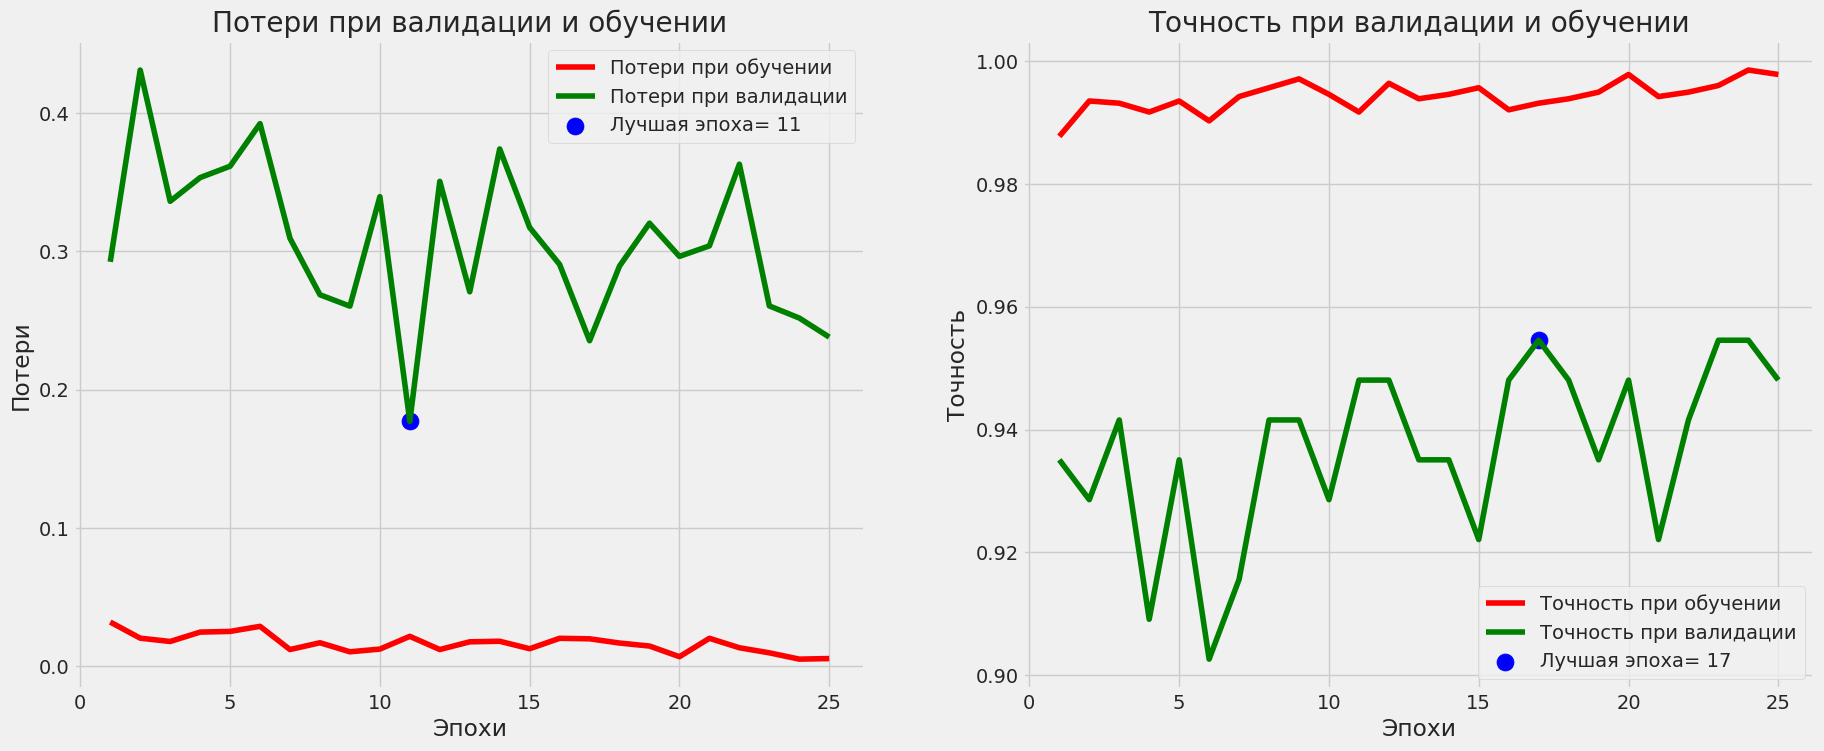

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9658 - loss: 0.1612
accuracy on the test set is 96.67 %



model was saved as ./EfficientNetB0-Cars-96.66.h5

class csv file was saved as ./class_dict.csv



In [47]:
# Задаем параметры обучения
epochs        = 25 # Количество эпох
patience      = 1 # количество эпох, в течение которых необходимо отрегулировать lr, если отслеживаемое значение не улучшится
stop_patience = 6 # количество эпох ожидания перед остановкой обучения, если отслеживаемое значение не улучшится
threshold     = .9
factor        = .5
dwell         = True # если True и отслеживаемая метрика не улучшаются по сравнению с текущей эпохой, возвращают веса модели к весам предыдущей эпохи.
freeze        = False #
ask_epoch     = 10 # количество эпох, которые нужно выполнить, прежде чем спросить, хотите ли вы остановить обучение
batches       = train_steps

# utils.LRA реализует вывод информации прямо в процессе обучения
#  Об этом стоит рассказать подробнее, но это тема для отдельной статьи
# callbacks = [LRA(model = model,
#                        base_model = base_model,
#                        patience=patience,
#                        stop_patience = stop_patience,
#                        threshold = threshold,
#                        factor = factor,
#                        dwell = dwell,
#                        batches = batches,
#                        initial_epoch = 0,
#                        epochs = epochs,
#                        ask_epoch = ask_epoch )]
# Запускаем обучение модели и сохраняем историю обучения
history = model.fit (x = train_gen,  epochs = epochs, verbose = 1, validation_data = valid_gen, validation_steps = None,  shuffle = False,  initial_epoch = 0)

# Рисуем график обучения и выводим
tr_plot(history,0)
# Проверяем точность модели на тестовой выборке и выводим результат тестирования
save_dir = './'
subject = 'Cars'

acc = model.evaluate( test_gen, batch_size = test_batch_size, verbose = 1, steps=test_steps, return_dict = False)[1]*100
msg = f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))

# Сохраняем модель в файл, его потом можно загрузить и использовать без обучения для классификации изображений
save_id   = str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc  = os.path.join(save_dir, save_id)
model.save(save_loc)
generator = train_gen
scale     = 1
result    = saver(save_dir, model, model_name, subject, acc, img_size, scale,  generator)

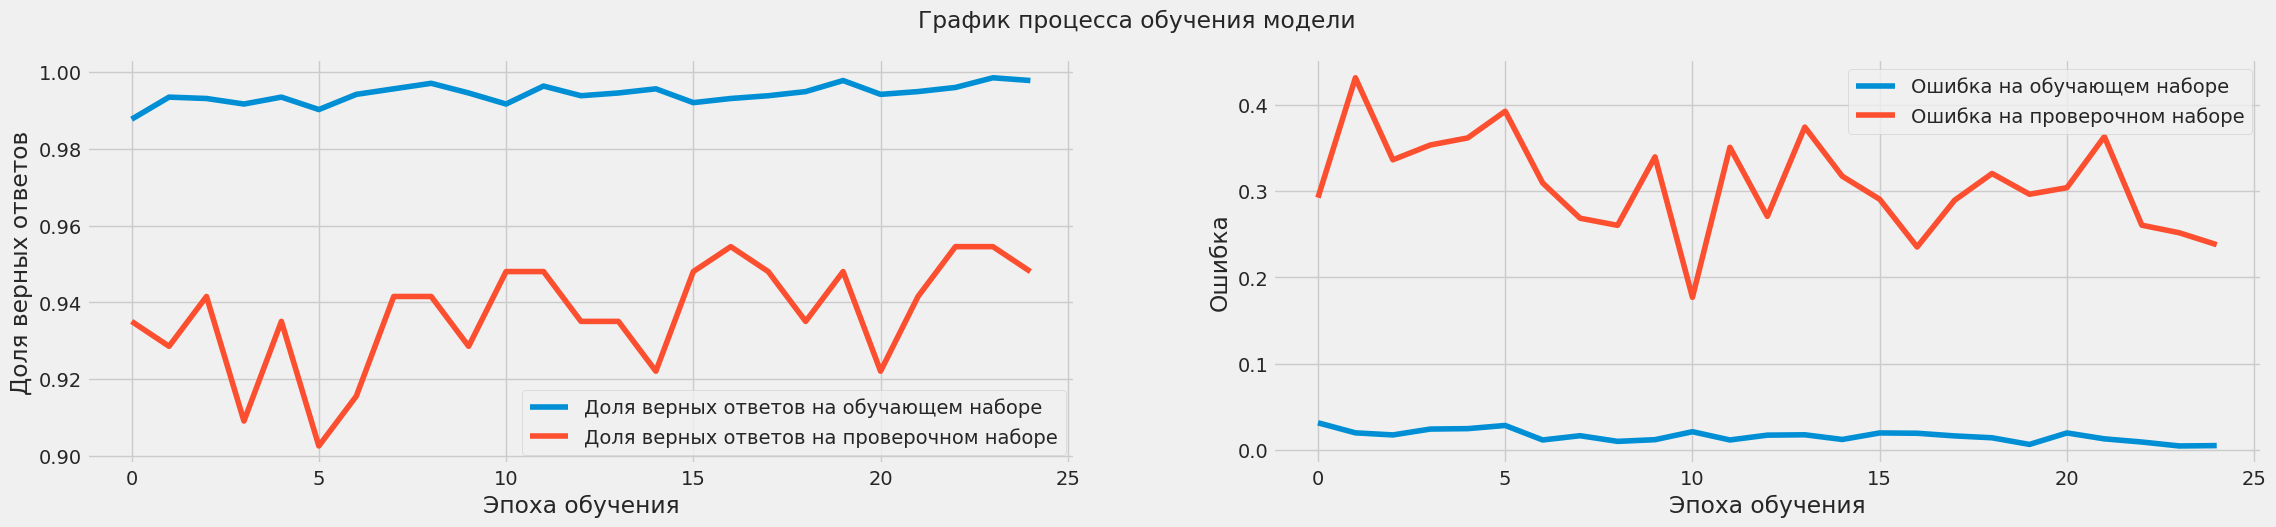

In [48]:
# Вывод графиков точности и ошибки
figsize = (25,5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
fig.suptitle('График процесса обучения модели')
ax1.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
ax1.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
ax1.xaxis.get_major_locator().set_params(integer=True)
ax1.set_xlabel('Эпоха обучения')
ax1.set_ylabel('Доля верных ответов')
ax1.legend()

ax2.plot(history.history['loss'],
            label='Ошибка на обучающем наборе')
ax2.plot(history.history['val_loss'],
            label='Ошибка на проверочном наборе')
ax2.xaxis.get_major_locator().set_params(integer=True)
ax2.set_xlabel('Эпоха обучения')
ax2.set_ylabel('Ошибка')
ax2.legend()
plt.show()

In [49]:
scores = model.evaluate(test_gen, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9664 - loss: 0.1631
